In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import style
import math
from sklearn import preprocessing
import matplotlib as mpl
import datetime

In [2]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("FR.PA", start="2009-01-01").reset_index()
df_full.head()

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,3.54,3.78,3.54,3.67,2.05,1736271
1,2009-01-05,3.68,3.77,3.55,3.73,2.08,2843871
2,2009-01-06,3.72,4.07,3.72,4.05,2.26,3290877
3,2009-01-07,4.01,4.08,3.89,3.94,2.20,2534205
4,2009-01-08,3.83,3.88,3.77,3.81,2.12,1805292


## Plot Moving Average

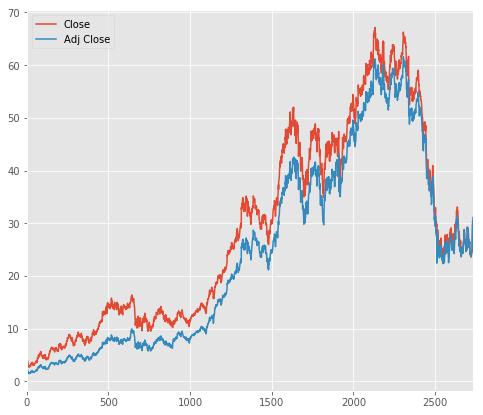

In [3]:
adj_close_px = df_full['Adj Close']
close_px = df_full['Close']
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='Close')
adj_close_px.plot(label='Adj Close')
plt.legend()

In [4]:
close_px = df_full['Close']
mavg = close_px.rolling(window=100).mean()

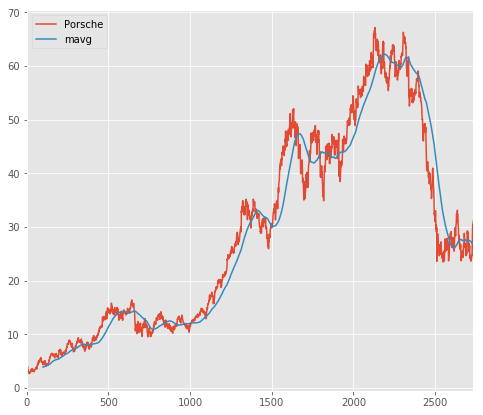

In [5]:
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='Porsche')
mavg.plot(label='mavg')
plt.legend()

## Return Deviation

Expected Return measures the mean, or expected value, of the probability distribution of investment returns.

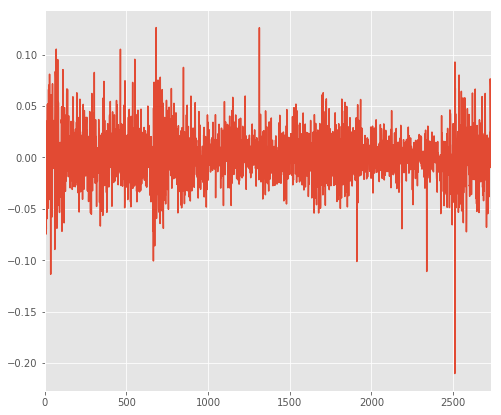

In [6]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

## Predict Stock Prices

In [29]:
df = df_full.loc[:,['Close','Volume']]
df['HL_PCT'] = (df_full['High'] - df_full['Low']) / df_full['Close'] * 100.0
df['PCT_change'] = (df_full['Close'] - df_full['Open']) / df_full['Open'] * 100.0
df = df_full.loc[:,['Close','Volume','Low','High','Open']]

### Data Preprossesing


In [28]:
df.fillna(value=-99999, inplace=True)

In [10]:
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Close'
df['label'] = df[forecast_col].shift(-1)
df = df.drop(df[df.isnull().any(axis=1)].index)
X = np.array(df.drop(['label'], 1))

In [27]:
df.head()


,Close,Volume,Low,High,Open,label,Forecast
0,3.67,1736271,3.54,3.78,3.54,3.73,NaN
1,3.73,2843871,3.55,3.77,3.68,4.05,NaN
2,4.05,3290877,3.72,4.07,3.72,3.94,NaN
3,3.94,2534205,3.89,4.08,4.01,3.81,NaN
4,3.81,1805292,3.77,3.88,3.83,3.88,NaN


In [12]:
# We want to separate 10 percent of the data to forecast
forecast_out = int(math.ceil(0.1 * len(df)))

In [13]:
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

In [14]:
# Split the data into trainings data and test data
X_test = X[-forecast_out:]
X_train = X[:-forecast_out]

In [15]:
# Separate label and identify it as y
y = np.array(df['label'])
y_train = y[:-forecast_out]
y_test = y[-forecast_out:]

## Prediction

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Simple Linear Analysis

In [17]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

### Quadratic Discriminant Analysis

In [18]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [19]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

## Ridge Regression

In [20]:
clfridge = Ridge(alpha=.5)
clfridge.fit(X_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

## Lasso
The Lasso is a linear model that estimates sparse coefficients

In [21]:
clflasso = Lasso(alpha=0.1)
clflasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

### K Nearest Neighbor

In [22]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

## Evaluation

In [23]:
df[-forecast_out:]

,Close,Volume,Low,High,Open,label
2460,39.23,916059,38.94,39.79,39.50,39.27
2461,39.27,769832,38.63,39.30,39.18,40.18
2462,40.18,927861,39.27,40.36,39.31,40.23
2463,40.23,703807,39.89,40.34,40.18,38.28
2464,38.28,4051198,36.54,40.37,40.00,38.02
2465,38.02,1203549,37.90,38.71,38.31,38.20
2466,38.20,1096388,38.12,38.71,38.50,39.28
2467,39.28,1363522,38.39,39.56,38.60,39.99
2468,39.99,1334061,39.32,40.30,39.51,39.61
2469,39.61,948086,39.32,40.16,40.05,39.50


In [24]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceridge = clfridge.score(X_test,y_test)
confidencelasso = clflasso.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
# results
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The Ridge regression confidence is ', confidenceridge)
print('The Lasso confidence is ', confidencelasso)
print('The knn regression confidence is ', confidenceknn)

The linear regression confidence is  0.956792348693719
The quadratic regression 2 confidence is  0.9518441651222418
The quadratic regression 3 confidence is  0.9508205216824808
The Ridge regression confidence is  0.9547874396109323
The Lasso confidence is  0.9570802645663753
The knn regression confidence is  0.8328938132471733


In [25]:
# select the classifier to predict
forecast_set = clfpoly3.predict(X_test)

df['Forecast'] = np.nan
index = len(df)- forecast_out
for i in forecast_set:
    df['Forecast'].at[index] = i
    index += 1

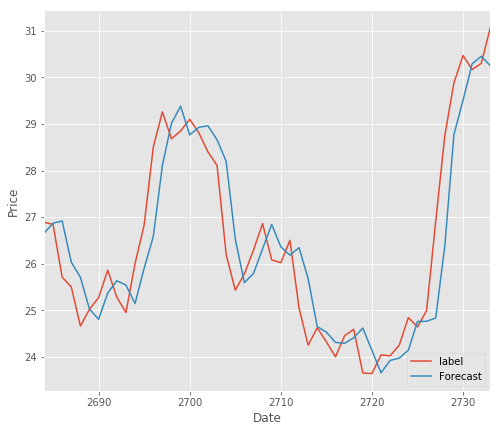

In [26]:
df['label'].tail(50).plot()
df['Forecast'].tail(50).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Result : Here we can see the Predicted stock price plot